/opt/anaconda3/envs/rnn_fly_env/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/rnn_fly_env/lib/python3.9/site-packages/numpy/core/_methods.py:258: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


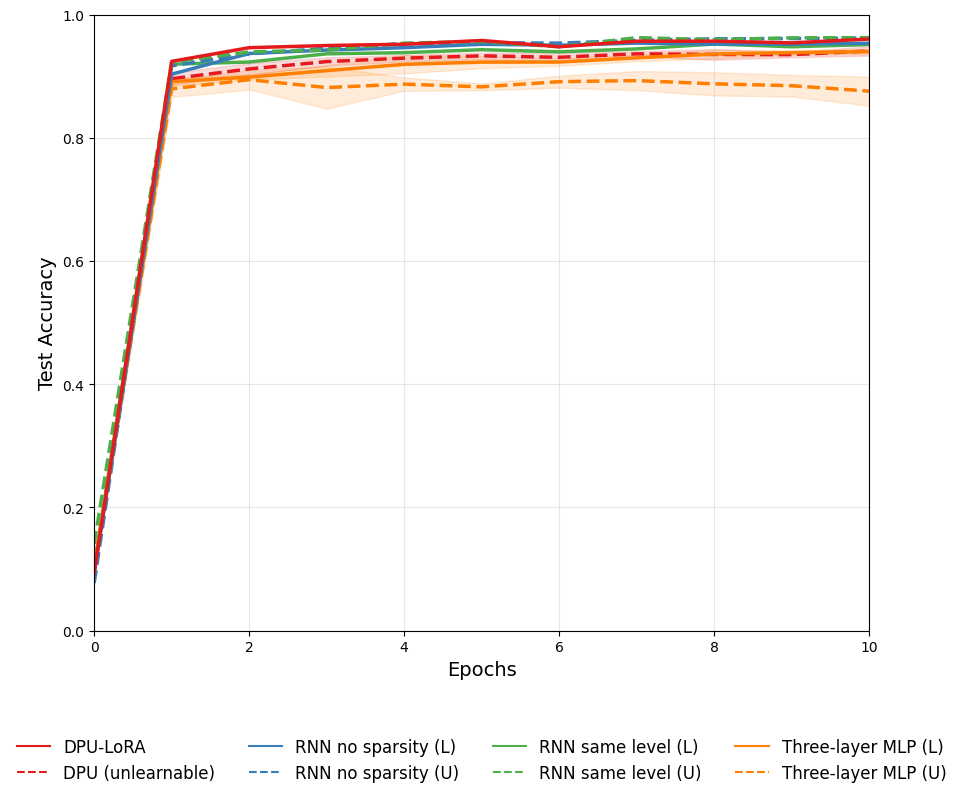

In [111]:
import os
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

RESULTS_DIR = "./results/"
SELECTED_SAMPLE = "100%"  # option: "1%", "2%", "5%", "100%"

COLOR_MAP = {
    "DPU_LoRA": "#E41A1C",
    "Unlearnable_DPU": "#E41A1C",
    "Learnable_RNN_No_Sparsity": "#377EB8",
    "Unlearnable_RNN_No_Sparsity": "#377EB8",
    "Learnable_RNN_Same_Sparsity": "#4DAF4A", 
    "Unlearnable_RNN_Same_Sparsity": "#4DAF4A",
    "Unlearnable_SIO_DPU": "#F781BF",
  
    "Unlearnable_Threehidden_MLP": "#FF7F00",
    "Learnable_Threehidden_MLP": "#FF7F00"
}
LINE_STYLE = {
    "DPU_LoRA": "-",
    "Unlearnable_DPU": "--",
    "Learnable_RNN_No_Sparsity": "-",
    "Unlearnable_RNN_No_Sparsity": "--",
    "Learnable_RNN_Same_Sparsity": "-",
    "Unlearnable_RNN_Same_Sparsity": "--",
    "Learnable_RNN_Same_Sparsity_Level": "-",
    "Unlearnable_RNN_Same_Sparsity_Level": "--",
    "Learnable_Threehidden_MLP": "-",
    "Unlearnable_Threehidden_MLP": "--",
    "Unlearnable_SIO_DPU": "--",
}

def load_results():
    target_samples = {"1%":60, "2%":120, "5%":300, "10%":600, "100%":None}[SELECTED_SAMPLE]
  
    data = {}
    pattern = re.compile(r"^(?P<exp>\w+?)(_fewshot_\d+)?(_trial\d+)?(\.signed)?\.pkl$")
  
    for fname in os.listdir(RESULTS_DIR):
        match = pattern.match(fname)
        if not match: continue
      
        exp_name = match.group("exp")
        if "_fewshot" in fname:
            samples = int(fname.split("_fewshot_")[1].split("_")[0])
            if samples != target_samples: continue
        else:
            if target_samples is not None: continue
      
        with open(os.path.join(RESULTS_DIR, fname), "rb") as f:
            results = pickle.load(f)
      
        key = (exp_name, "learnable" if "Learnable" in exp_name else "unlearnable")
        data.setdefault(key, []).append(results['epoch_test_acc'])
  
    return data

def create_custom_legend():
    legend_elements = [
        Line2D([0], [0], color=COLOR_MAP["DPU_LoRA"], ls="-",  label="DPU-LoRA"),
        Line2D([0], [0], color=COLOR_MAP["Unlearnable_DPU"], ls="--", label="DPU (unlearnable)"),
        Line2D([0], [0], color=COLOR_MAP["Learnable_RNN_No_Sparsity"], ls="-",  label="RNN no sparsity (L)"),
        Line2D([0], [0], color=COLOR_MAP["Learnable_RNN_No_Sparsity"], ls="--", label="RNN no sparsity (U)"),
        Line2D([0], [0], color=COLOR_MAP["Learnable_RNN_Same_Sparsity"], ls="-",  label="RNN same level (L)"),
        Line2D([0], [0], color=COLOR_MAP["Learnable_RNN_Same_Sparsity"], ls="--", label="RNN same level (U)"),
      
        Line2D([0], [0], color=COLOR_MAP["Learnable_Threehidden_MLP"], ls="-", label="Three-layer MLP (L)"),
        Line2D([0], [0], color=COLOR_MAP["Unlearnable_Threehidden_MLP"], ls="--", label="Three-layer MLP (U)"),
    ]
    return legend_elements

def plot_results(data):
    plt.figure(figsize=(10, 8))
  
    x_max = 0
  
    for (exp_name, _), acc_list in data.items():
        acc_matrix = np.array(acc_list)
        epochs = acc_matrix.shape[1]
      
        mean = np.mean(acc_matrix, axis=0)
        std = np.std(acc_matrix, axis=0, ddof=1)
      
        target_samples = {"1%":60, "2%":120, "5%":300,"10%":600, "100%":0.1}[SELECTED_SAMPLE]
        x = np.arange(epochs) * target_samples*10
        x_max = max(x_max, x[-1])
      
        plt.plot(
            x, mean,
            color=COLOR_MAP[exp_name],
            linestyle=LINE_STYLE[exp_name],
            linewidth=2.5
        )
      
        plt.fill_between(
            x, mean - std, mean + std,
            color=COLOR_MAP[exp_name],
            alpha=0.15
        )
  
    plt.xlabel("Training Samples" if SELECTED_SAMPLE != "100%" else "Epochs", fontsize=14)
    plt.ylabel("Test Accuracy", fontsize=14)
    plt.xlim(0, x_max*1.0)
    plt.ylim(0, 1.0)
    plt.grid(True, alpha=0.3)
  
    legend = plt.legend(
        handles=create_custom_legend(),
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        ncol=4,
        frameon=False,
        fontsize=12
    )
  
    plt.savefig("./results/figures/performance_curve.pdf", bbox_inches="tight")
    plt.show()

if __name__ == "__main__":
    experiment_data = load_results()
    plot_results(experiment_data)

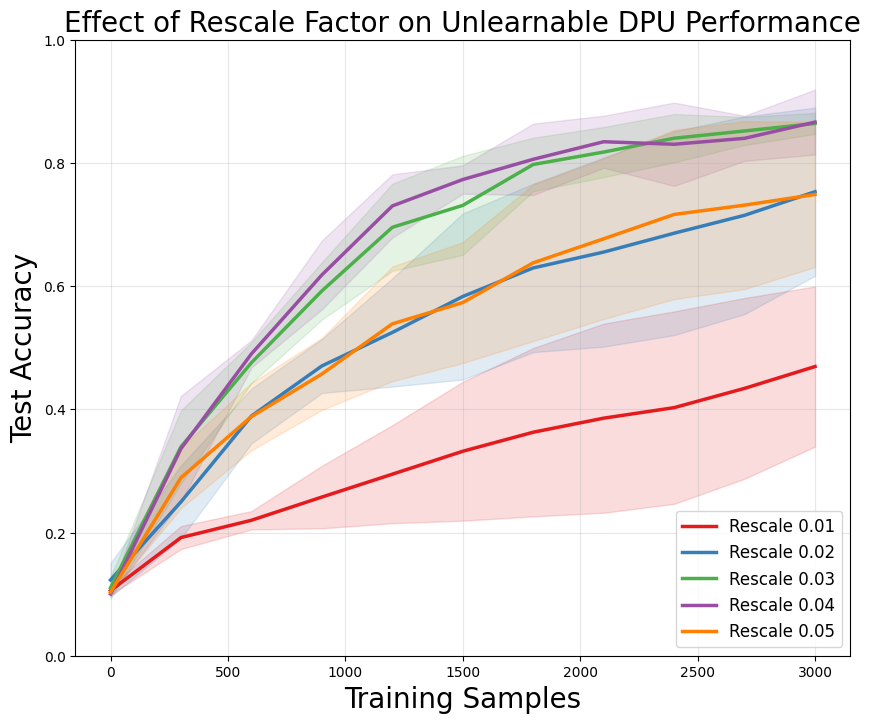

In [112]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

RESULTS_DIR = "./results/"
COLORS = ["#E41A1C", "#377EB8", "#4DAF4A", "#984EA3", "#FF7F00"]  # Color scheme from plot_results

def load_rescale_results():
    data = {}
    for fname in os.listdir(RESULTS_DIR):
        if fname.startswith("Unlearnable_DPU_rescale_") and fname.endswith(".signed.pkl"):
            # Extract rescale factor from filename
            rescale_factor = float(fname.split("_rescale_")[1].split("_")[0])
            trial_num = int(fname.split("trial")[1].split(".")[0])
            
            with open(os.path.join(RESULTS_DIR, fname), "rb") as f:
                results = pickle.load(f)
                # Initialize list for this rescale factor if not exists
                data.setdefault(rescale_factor, []).append(results['epoch_test_acc'])
    
    return data

def plot_rescale_comparison():
    plt.figure(figsize=(10, 8))
    
    data = load_rescale_results()
    
    # Plot each rescale factor
    for i, (rescale_factor, acc_list) in enumerate(sorted(data.items())):
        # Convert list of accuracy lists to numpy array
        acc_matrix = np.array(acc_list)
        epochs = acc_matrix.shape[1]
        
        # Calculate mean and standard deviation across trials
        mean = np.mean(acc_matrix, axis=0)
        std = np.std(acc_matrix, axis=0, ddof=1)
        
        # Since these are fewshot_300 results
        x = np.arange(epochs) * 300
        
        # Plot mean line
        plt.plot(
            x, mean,
            color=COLORS[i % len(COLORS)],
            label=f'Rescale {rescale_factor}',
            linewidth=2.5
        )
        
        # Plot standard deviation as shaded area
        plt.fill_between(
            x, mean - std, mean + std,
            color=COLORS[i % len(COLORS)],
            alpha=0.15
        )
    
    plt.xlabel("Training Samples", fontsize=20)
    plt.ylabel("Test Accuracy", fontsize=20)
    plt.ylim(0, 1.0)
    plt.grid(True, alpha=0.3)
    
    plt.legend(loc='lower right', fontsize=12)
    plt.title("Effect of Rescale Factor on Unlearnable DPU Performance", fontsize=20)
    
    plt.savefig("./results/figures/rescale_comparison.pdf", bbox_inches="tight")
    plt.show()

if __name__ == "__main__":
    plot_rescale_comparison()